In [58]:
suppressWarnings({
    library(lmerTest)
    library(lme4)
    library(ggplot2)
    library(dplyr)
    library(tidyr)
    library(sjPlot)
    library(IRdisplay)
})


# Investigating MHWs + Phytoplankton Performance Response via LMMs

Tony Cannistra, May 2020

**Purpose**: To experiment with linear mixed effects models to examine whether a significant relationship exists between latitude, sea surface temperature, and performance ratio during marine heatwave events. 

**Method**: Build a linear mixed model of performance ratio with the following effects: 

*Fixed*: 
* latitude + Latitude ^2
* mean_sst_event_year_local

*Random*:
* phytoplankton isolate
* season?

Perhaps season should be a fixed effect, especially since it likely does have control over the direction + shape of the curve. 

## Data

We compute individual isolate performance for all local heatwaves in [this notebook](../Individual_Isolate_performance.ipynb), and use these data below. 

In [4]:
mhwPerformance <- read.csv("../isolate_performance.csv")
mhwPerformance = mhwPerformance %>% mutate(isolate = factor(isolate))
head(mhwPerformance)

X,lat,lon,isolate,mhw,detriment_sum,relative_detriment_mean,detriment_mean,performance_diff_sum,performance_ratio_mean,intensity_cumulative,intensity_mean,duration,start_doy,peak_doy,current_year_sst_mean,perf_det_ratio,latbin,doy_bins
0,-74.875,164.625,1,4,2.632757,1,0.3290947,0,NA,11.680295,1.2978105,9,1,1,-1.202301,1,"(-75.026, -59.75]","(0.639, 91.25]"
1,-74.875,164.625,1,5,4.936420,1,0.3290947,0,NA,24.453109,1.5283193,16,21,32,-1.103370,1,"(-75.026, -59.75]","(0.639, 91.25]"
2,-74.875,164.625,1,11,5.594609,1,0.3290947,0,NA,3.379142,0.1877301,18,232,244,-1.168743,1,"(-75.026, -59.75]","(181.5, 271.75]"
3,-74.875,164.625,1,14,5.923704,1,0.3290947,0,NA,3.307942,0.1741022,19,196,201,-1.181397,1,"(-75.026, -59.75]","(181.5, 271.75]"
4,-74.875,164.625,1,37,3.620041,1,0.3290947,0,NA,1.872364,0.1560303,12,215,220,-1.219370,1,"(-75.026, -59.75]","(181.5, 271.75]"
5,-74.875,164.625,1,69,3.290947,1,0.3290947,0,NA,1.488562,0.1353238,11,133,138,-1.088333,1,"(-75.026, -59.75]","(91.25, 181.5]"


We need to adjust for the effect of hemisphere to "align" seasons and convert to "season" factor variables from "peak_doy" column:

In [5]:
mhwPerformance[between(mhwPerformance$lat, -90, 0), 'peak_doy'] = (mhwPerformance[between(mhwPerformance$lat, -90, 0), 'peak_doy'] - 180) %% 365

In [6]:
mhwPerformance = mhwPerformance %>%  
                    mutate(season = 
                           case_when(
                                (between(peak_doy, 0, 77) | between(peak_doy, 355, 366)) ~ "winter", # January 1 - March XX or December XX - December 31
                                between(peak_doy, 78, 170) ~ "spring", # March XX - June XX
                                between(peak_doy, 171, 295) ~ "summer", # June XX - September XX
                                between(peak_doy, 296, 354) ~ "fall" # September XX - December XX
                        )
                    )

In [7]:
head(mhwPerformance %>% select(peak_doy, season))

peak_doy,season
186,summer
217,summer
64,winter
21,winter
40,winter
323,fall


We'll clean up by dropping NAs and `Inf`s 

In [8]:
mhwPerformance = mhwPerformance %>% filter(!is.na(performance_ratio_mean)) %>% filter(is.finite(performance_ratio_mean))

We'll also **scale the input variables** for later, but the initial models will use the raw values: 

In [9]:
mhwPerformance = mhwPerformance %>%
    mutate(
        lat_scaled = scale(lat),
        sst_scaled = scale(current_year_sst_mean), 
    )

## Models

We'll start with a simple linear model:

In [10]:
simple_lm = lm(performance_ratio_mean ~ lat + I(lat^2) + current_year_sst_mean, data=mhwPerformance)
summary(simple_lm)


Call:
lm(formula = performance_ratio_mean ~ lat + I(lat^2) + current_year_sst_mean, 
    data = mhwPerformance)

Residuals:
    Min      1Q  Median      3Q     Max 
 -1.484  -0.284  -0.170  -0.054 219.670 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)   
(Intercept)            1.392e+00  4.609e-01   3.021  0.00253 **
lat                    1.711e-03  1.737e-03   0.985  0.32483   
I(lat^2)               2.055e-05  1.121e-04   0.183  0.85449   
current_year_sst_mean -9.608e-03  1.703e-02  -0.564  0.57263   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.583 on 4915 degrees of freedom
Multiple R-squared:  0.00093,	Adjusted R-squared:  0.0003202 
F-statistic: 1.525 on 3 and 4915 DF,  p-value: 0.2058


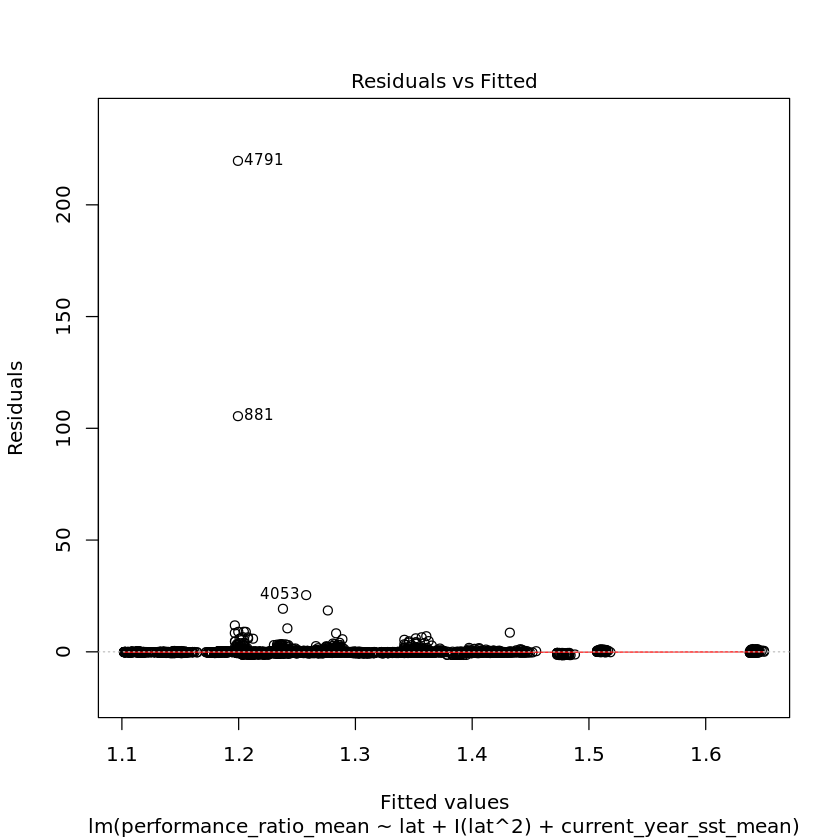

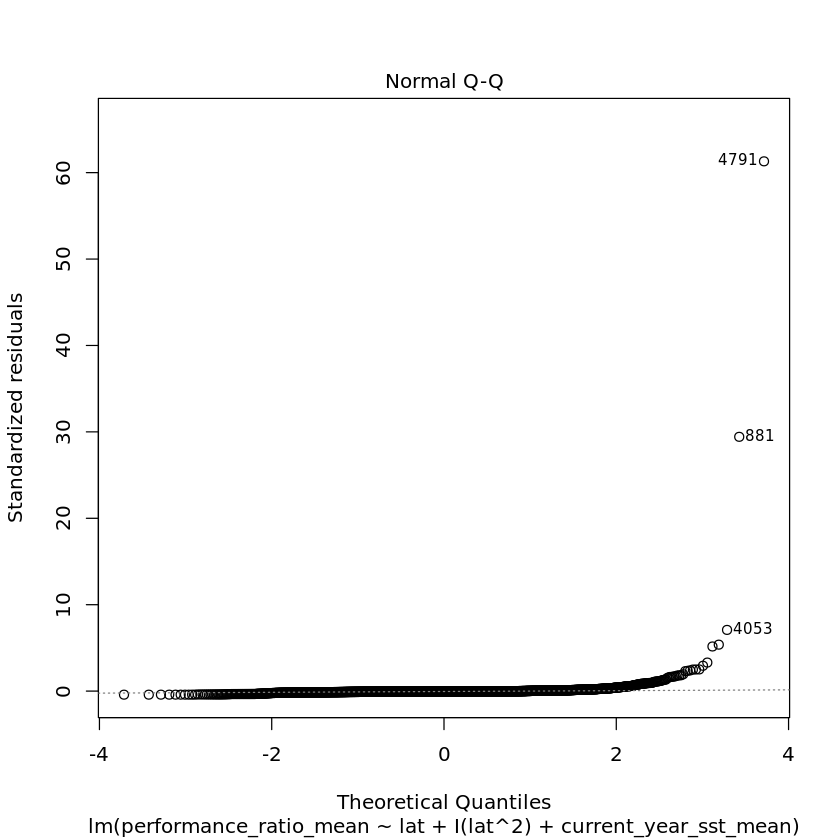

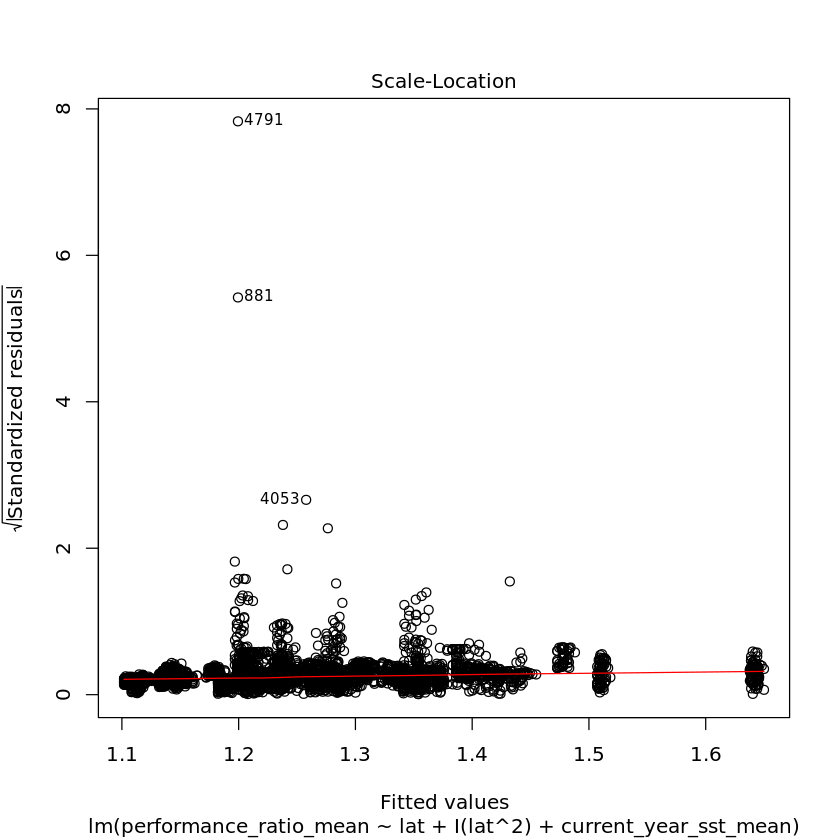

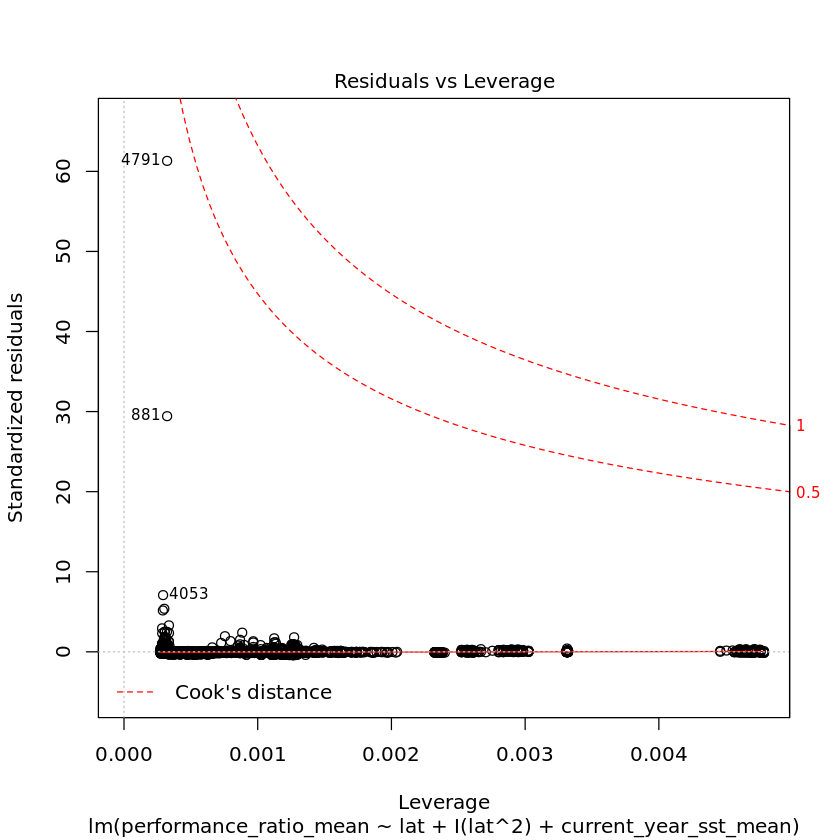

In [11]:
plot(simple_lm)

In [12]:
baseline_hline = geom_hline(yintercept=1, linetype='dashed', color='blue', size=0.6, alpha=0.6)

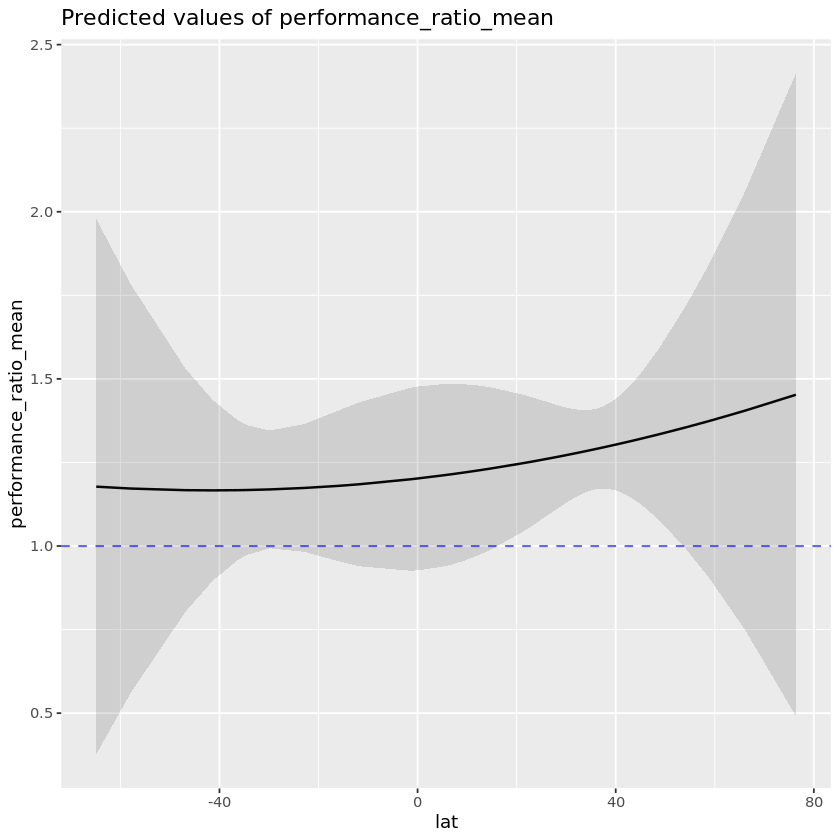

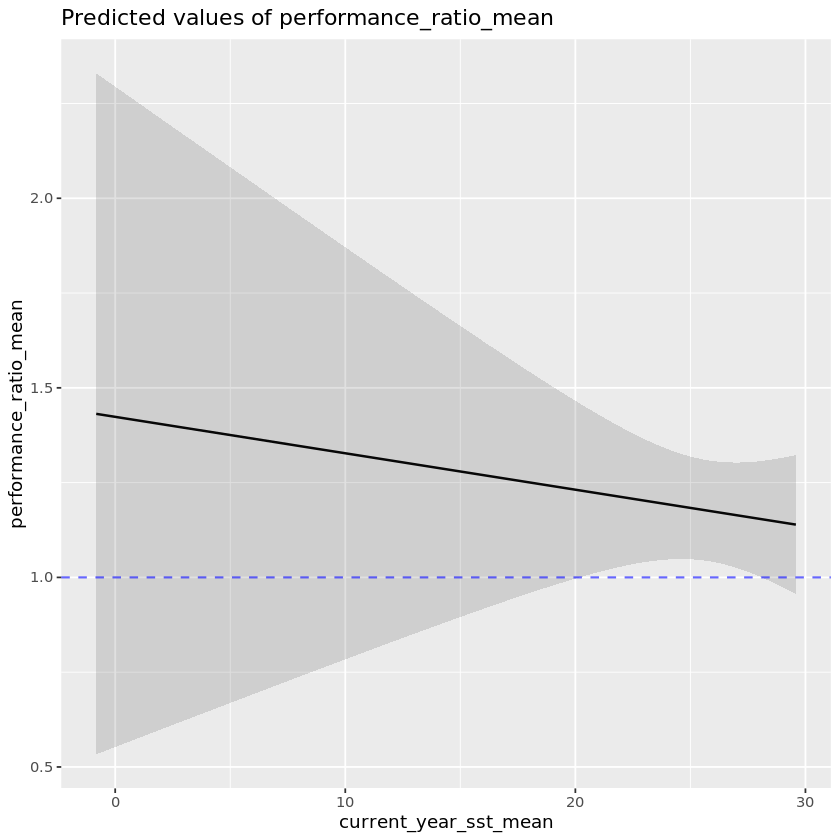

In [13]:
simple_plots = plot_model(simple_lm, type='pred')
simple_plots$lat + baseline_hline
simple_plots$current_year_sst_mean + baseline_hline

## Simple Model with Random Effects

Only `isolate` as random effect for now: 

In [15]:
simple_re = lmer(performance_ratio_mean ~ lat + I(lat^2) + current_year_sst_mean + (1|isolate), data=mhwPerformance)
summary(simple_re)

Warning message:
“Some predictor variables are on very different scales: consider rescaling”Warning message:
“Some predictor variables are on very different scales: consider rescaling”

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: performance_ratio_mean ~ lat + I(lat^2) + current_year_sst_mean +  
    (1 | isolate)
   Data: mhwPerformance

REML criterion at convergence: 26454.3

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-1.769 -0.043 -0.013  0.010 60.919 

Random effects:
 Groups   Name        Variance Std.Dev.
 isolate  (Intercept)  1.106   1.052   
 Residual             12.251   3.500   
Number of obs: 4919, groups:  isolate, 73

Fixed effects:
                       Estimate Std. Error        df t value Pr(>|t|)
(Intercept)           8.857e-01  1.124e+00 6.986e+01   0.788    0.434
lat                   1.728e-03  4.567e-03 5.076e+01   0.378    0.707
I(lat^2)              1.098e-04  2.802e-04 6.545e+01   0.392    0.697
current_year_sst_mean 1.472e-02  4.143e-02 7.074e+01   0.355    0.723

Correlation of Fixed Effects:
            (Intr) lat    I(l^2)
lat          0.237              
I(lat^2)    -0.940 -0

Model contains polynomial or cubic / quadratic terms. Consider using `terms="lat [all]"` to get smooth plots. See also package-vignette 'Marginal Effects at Specific Values'.
Model contains polynomial or cubic / quadratic terms. Consider using `terms="current_year_sst_mean [all]"` to get smooth plots. See also package-vignette 'Marginal Effects at Specific Values'.


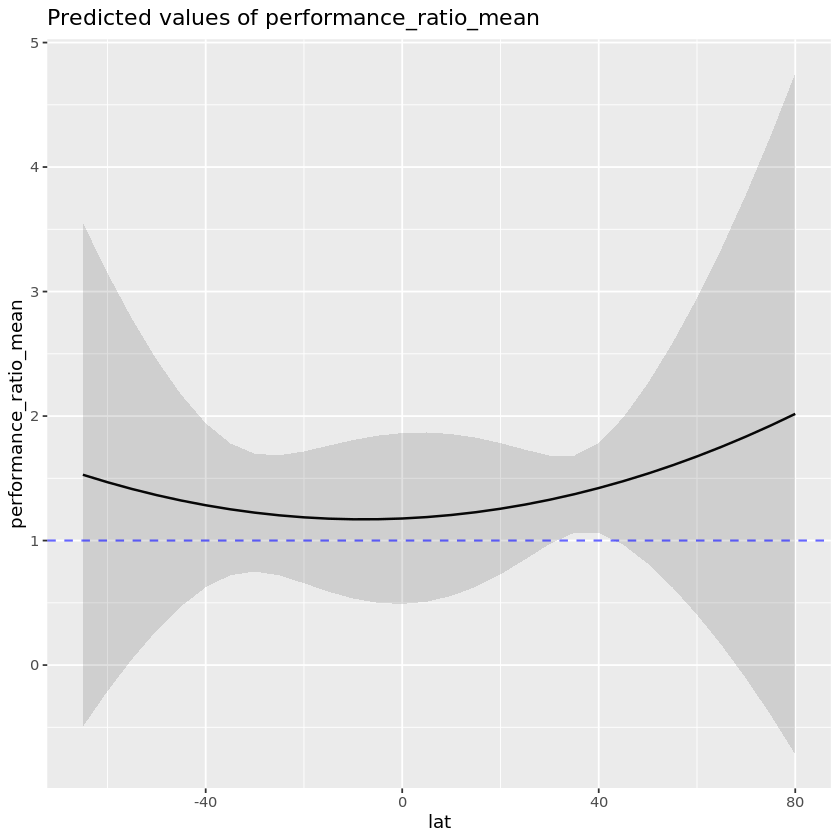

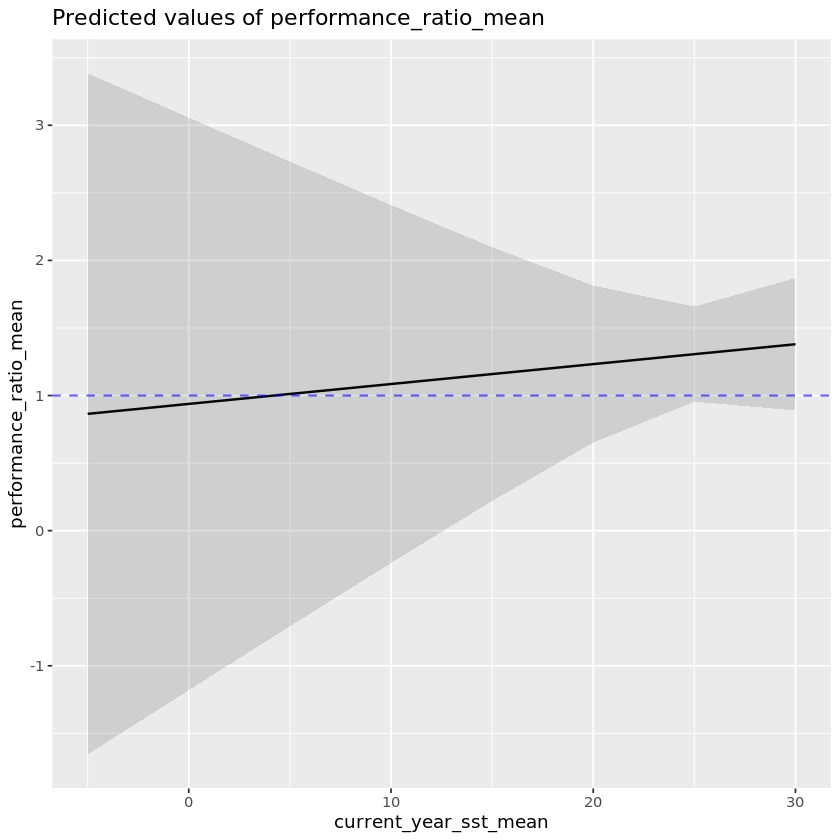

In [16]:
simple_re_plots = plot_model(simple_re, type='pred')
simple_re_plots$lat + baseline_hline
simple_re_plots$current_year_sst_mean + baseline_hline

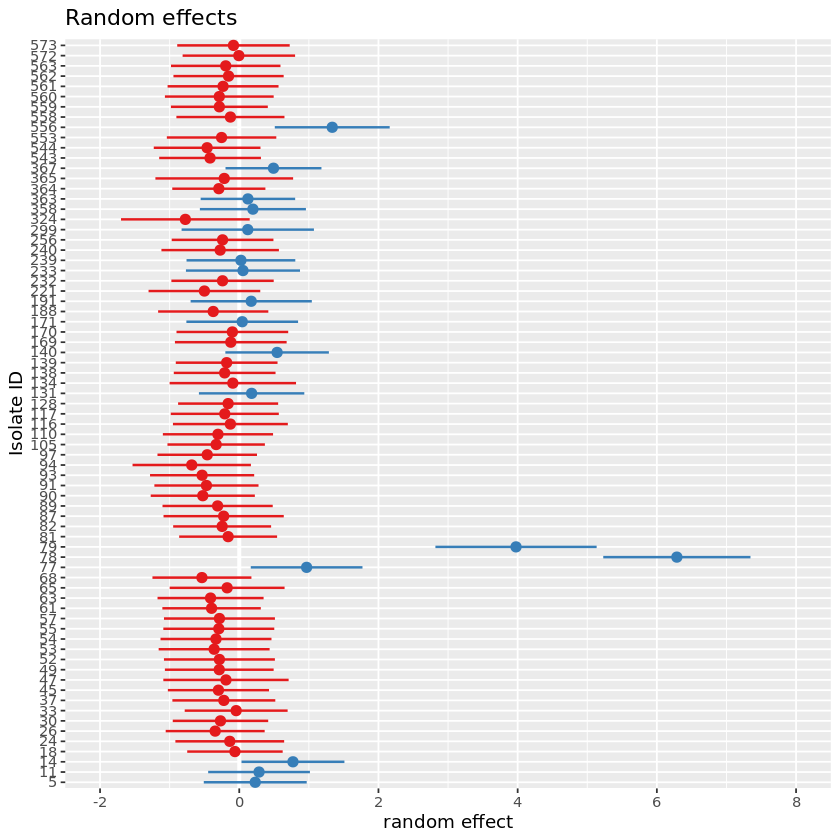

In [17]:
plot_model(simple_re, type='re') + xlab("Isolate ID") + ylab('random effect')

`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'


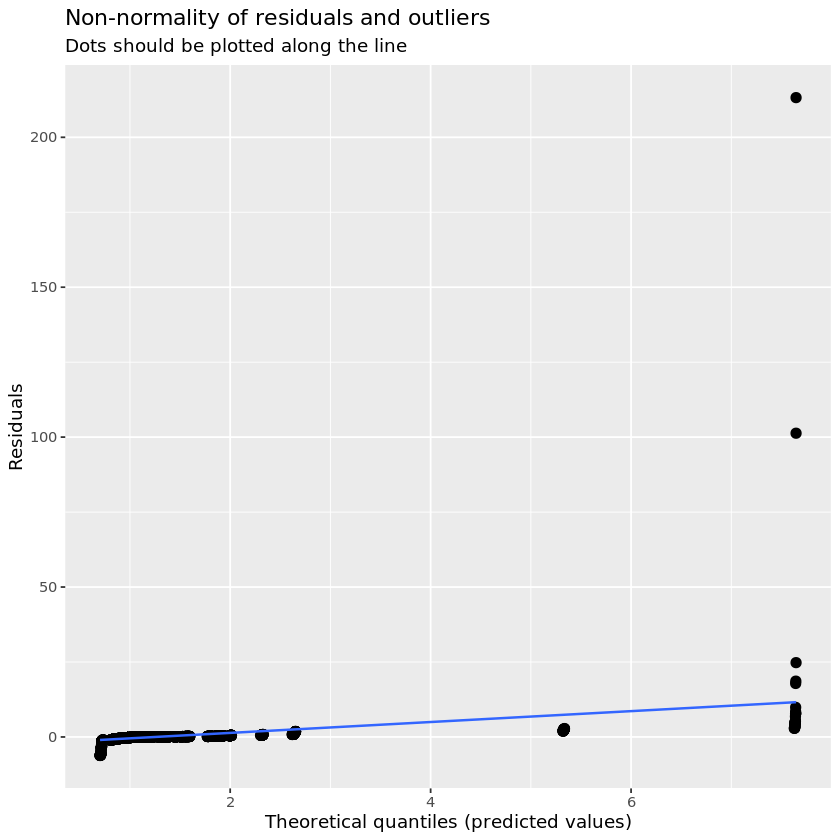

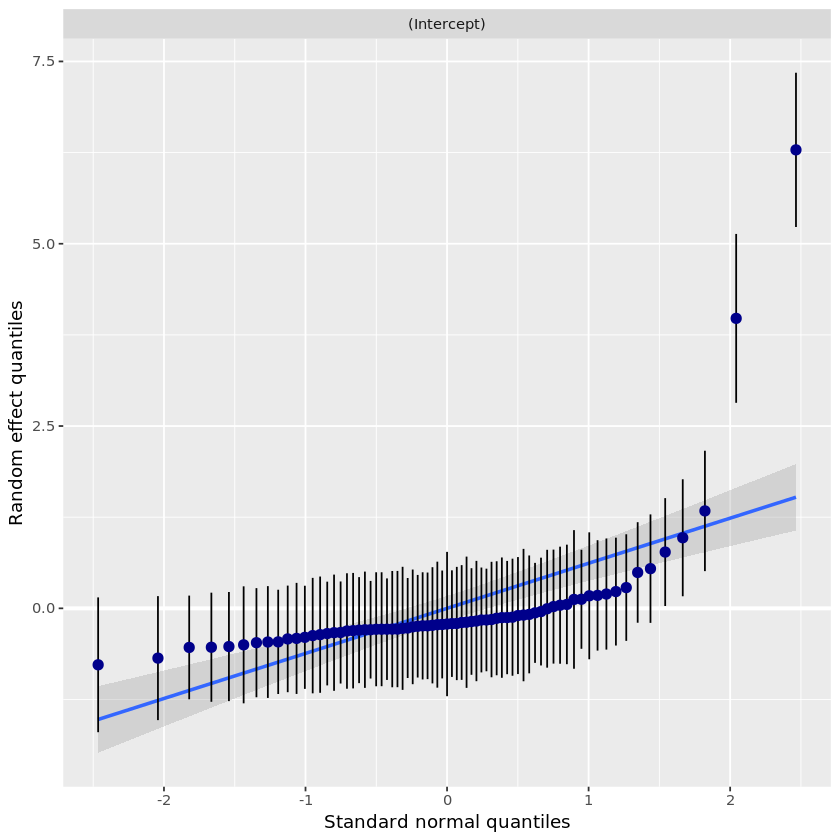

`geom_smooth()` using formula 'y ~ x'


[[1]]

[[2]]
[[2]]$isolate


[[3]]

[[4]]


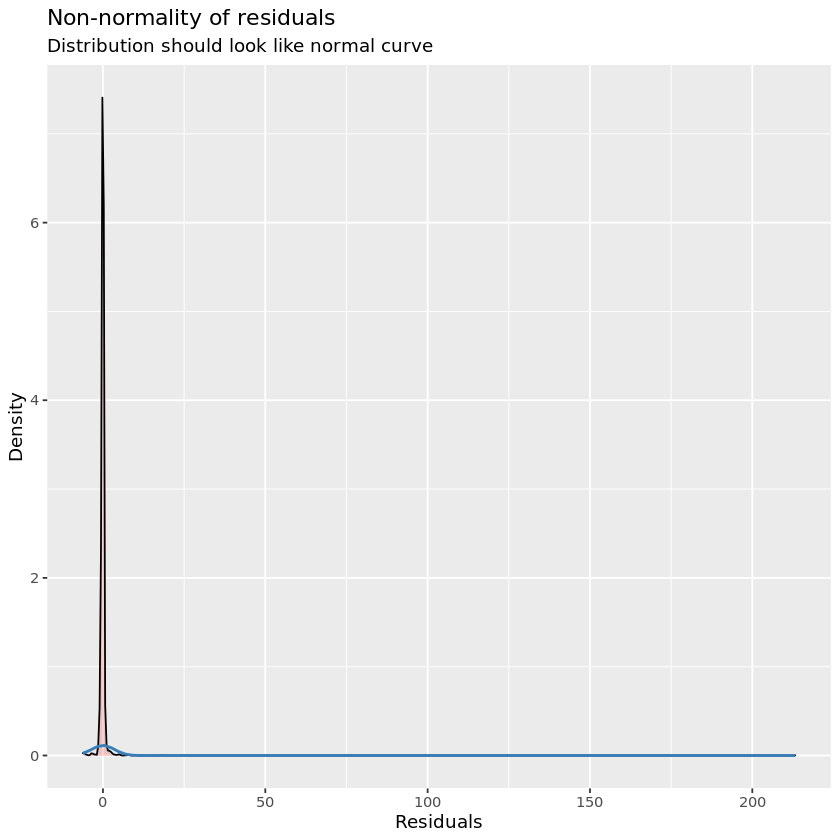

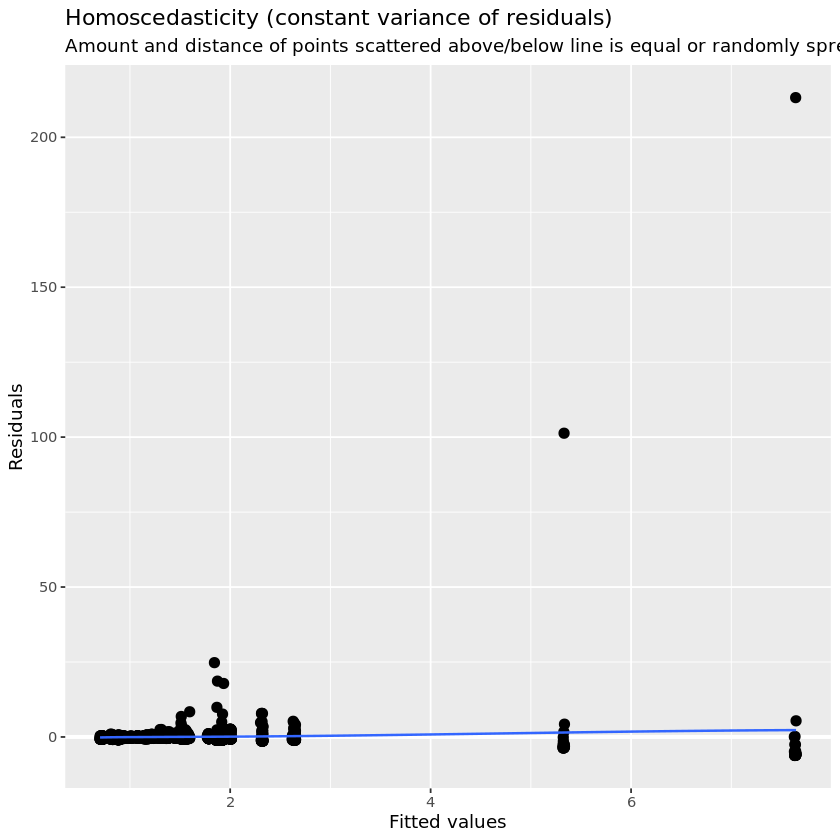

In [18]:
plot_model(simple_re, type='diag')

## Is `season` a random or fixed effect?

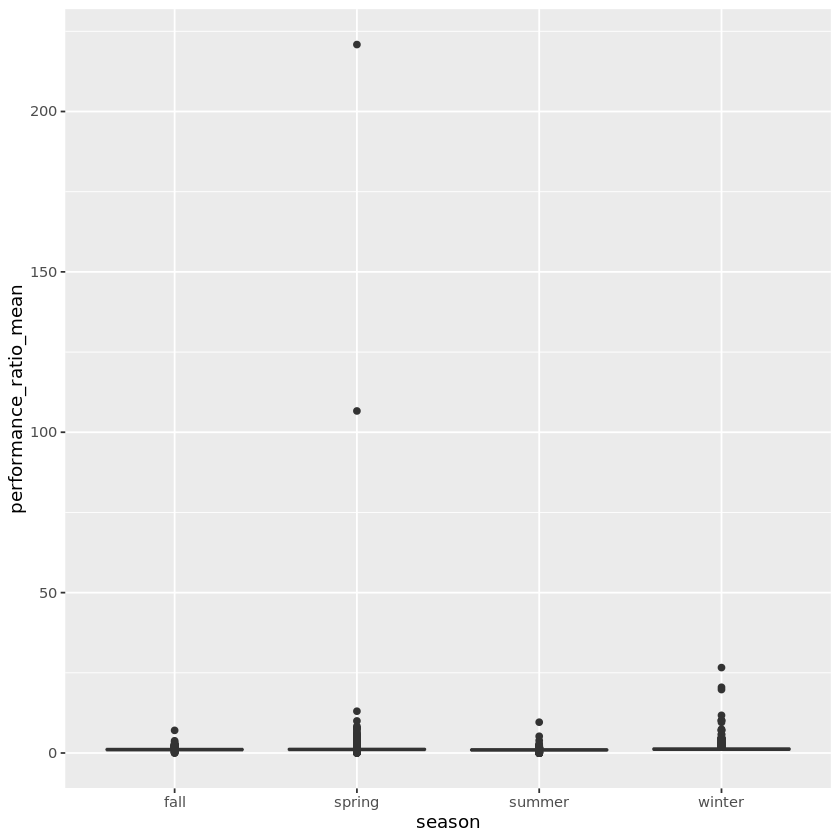

In [19]:
ggplot(mhwPerformance, aes(x = season, y = performance_ratio_mean)) + geom_boxplot()

Warning message:
“Removed 95 rows containing non-finite values (stat_boxplot).”

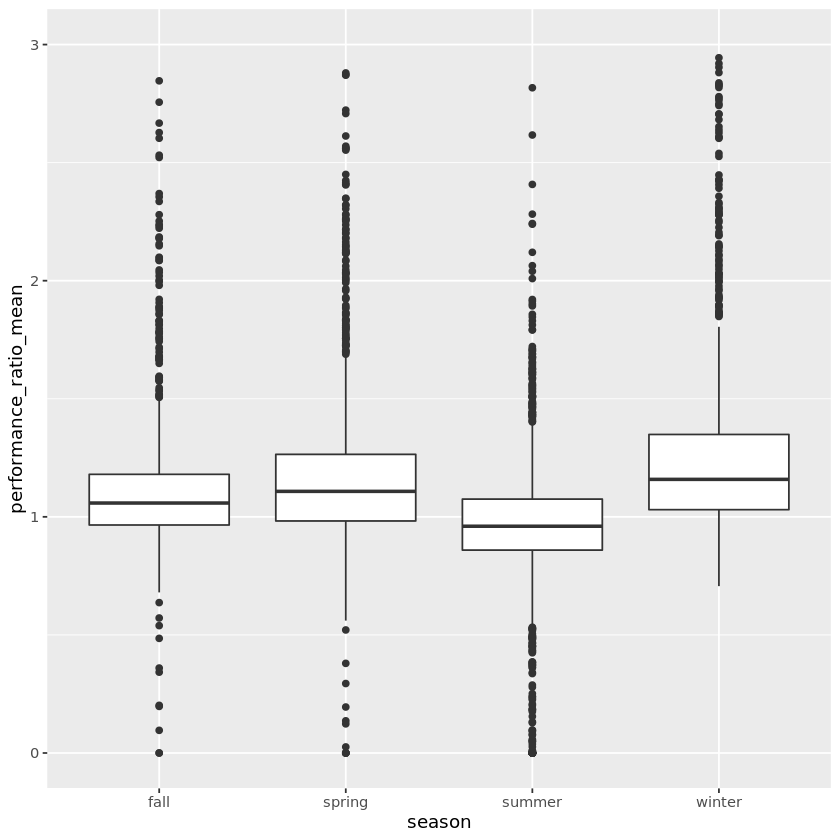

In [20]:
ggplot(mhwPerformance, aes(x = season, y = performance_ratio_mean)) + geom_boxplot() + ylim(0, 3)

Warning message:
“Removed 36 rows containing non-finite values (stat_boxplot).”

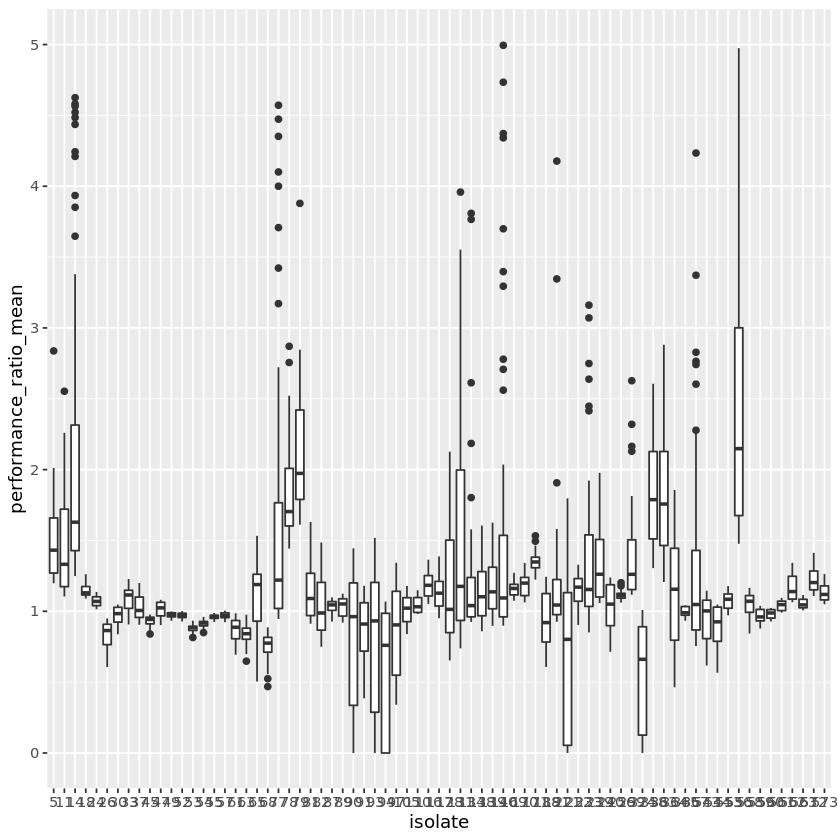

In [21]:
ggplot(mhwPerformance, aes(x = isolate, y = performance_ratio_mean)) + geom_boxplot() + ylim(0, 5)

Intuitively, since it's likely that season has a significant (mechanistic?) effect on performance impacts, it should probably be a fixed parameter?

**Season as Fixed Effect**

In [22]:
season_re = lmer(performance_ratio_mean ~ lat + I(lat^2) + current_year_sst_mean + season  +  (1 | isolate), data=mhwPerformance)
summary(season_re)

Warning message:
“Some predictor variables are on very different scales: consider rescaling”Warning message:
“Some predictor variables are on very different scales: consider rescaling”

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: performance_ratio_mean ~ lat + I(lat^2) + current_year_sst_mean +  
    season + (1 | isolate)
   Data: mhwPerformance

REML criterion at convergence: 26423.5

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-1.747 -0.089 -0.014  0.055 61.004 

Random effects:
 Groups   Name        Variance Std.Dev.
 isolate  (Intercept)  1.186   1.089   
 Residual             12.154   3.486   
Number of obs: 4919, groups:  isolate, 73

Fixed effects:
                        Estimate Std. Error         df t value Pr(>|t|)   
(Intercept)            9.768e-01  1.161e+00  7.466e+01   0.842  0.40265   
lat                    2.243e-03  4.705e-03  5.181e+01   0.477  0.63547   
I(lat^2)               5.260e-05  2.876e-04  6.779e+01   0.183  0.85544   
current_year_sst_mean  6.071e-03  4.248e-02  7.360e+01   0.143  0.88675   
seasonspring           4.674e-01  1.624e-01  4.845e+03   2.878  0.00402 **
seasonsum

Model contains polynomial or cubic / quadratic terms. Consider using `terms="lat [all]"` to get smooth plots. See also package-vignette 'Marginal Effects at Specific Values'.
Model contains polynomial or cubic / quadratic terms. Consider using `terms="current_year_sst_mean [all]"` to get smooth plots. See also package-vignette 'Marginal Effects at Specific Values'.
Model contains polynomial or cubic / quadratic terms. Consider using `terms="season [all]"` to get smooth plots. See also package-vignette 'Marginal Effects at Specific Values'.


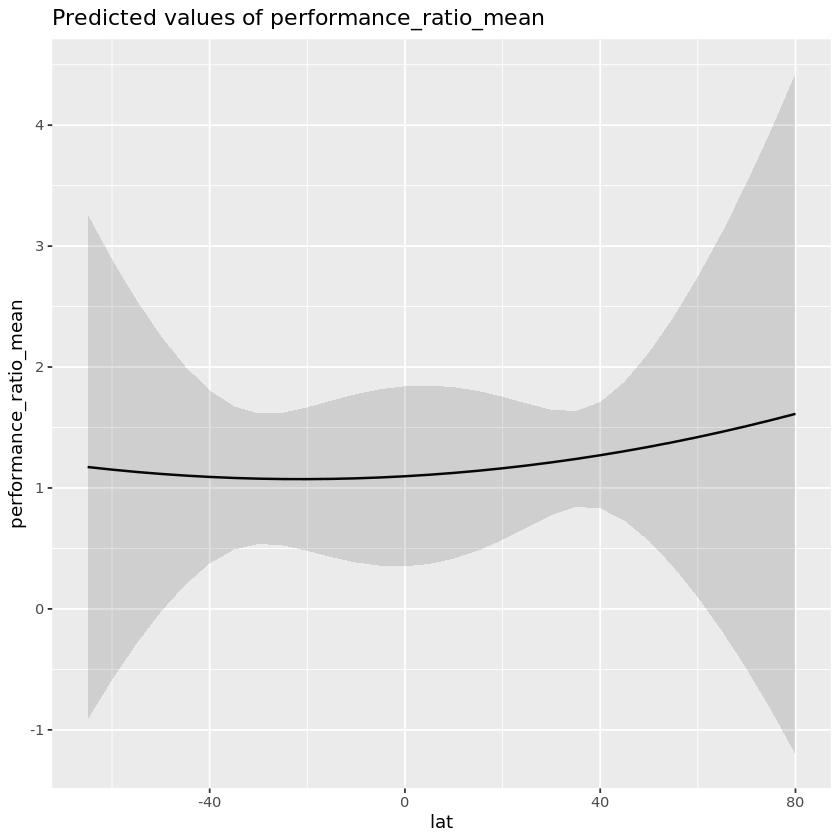

$lat

$current_year_sst_mean

$season


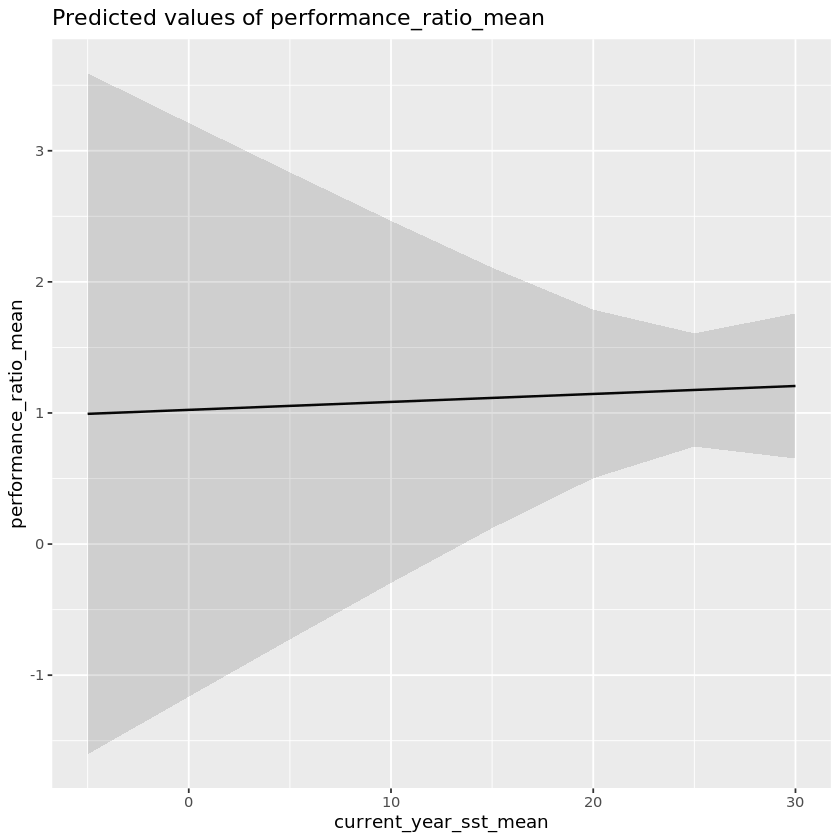

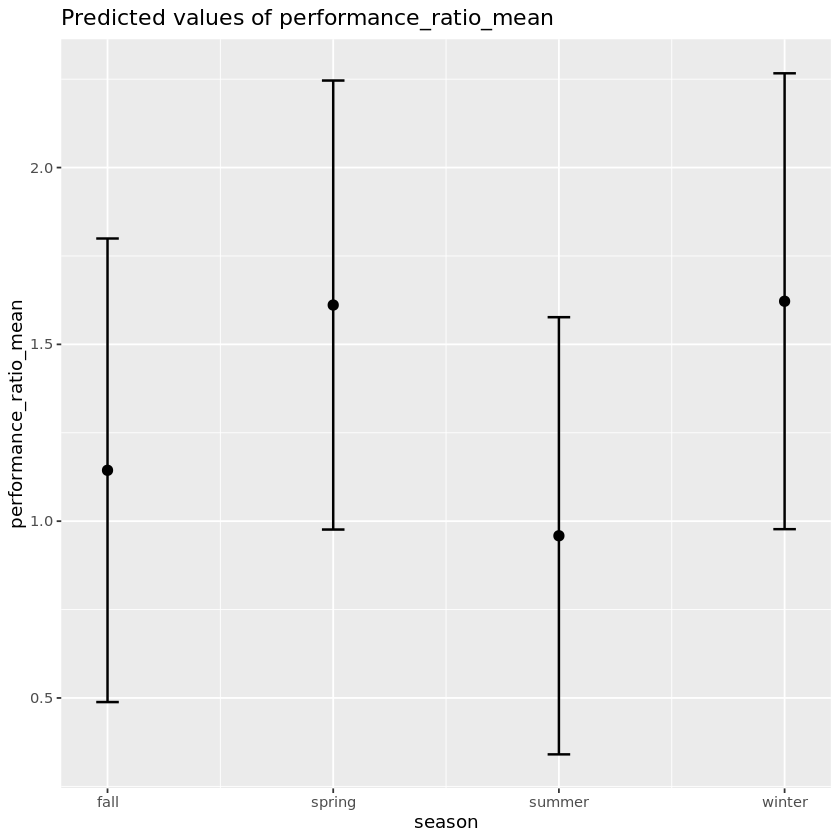

In [23]:
plot_model(season_re, type='pred')

`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'


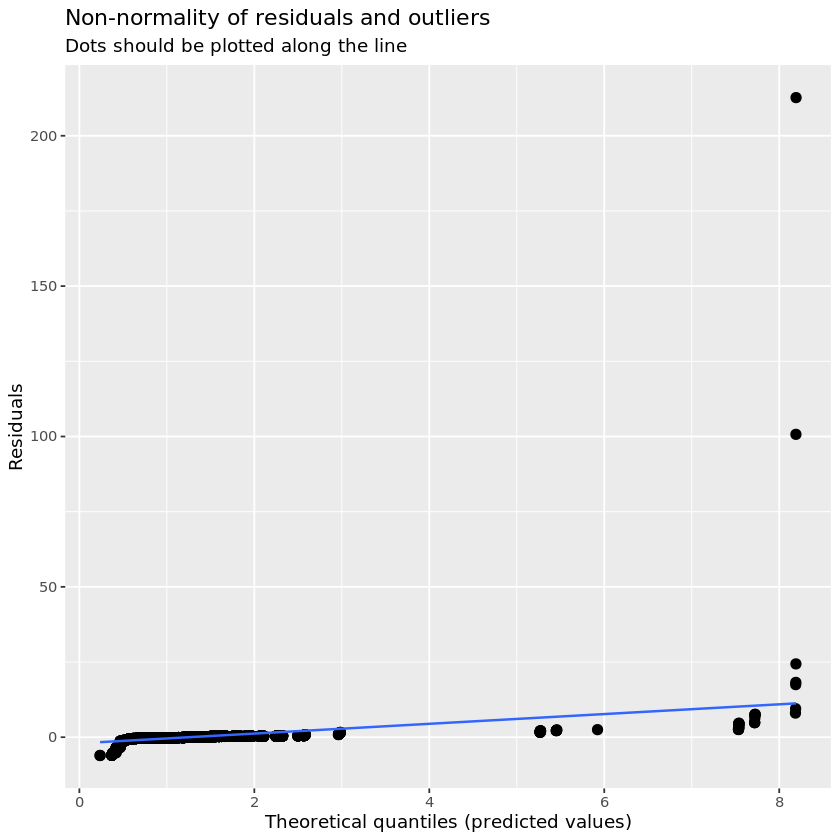

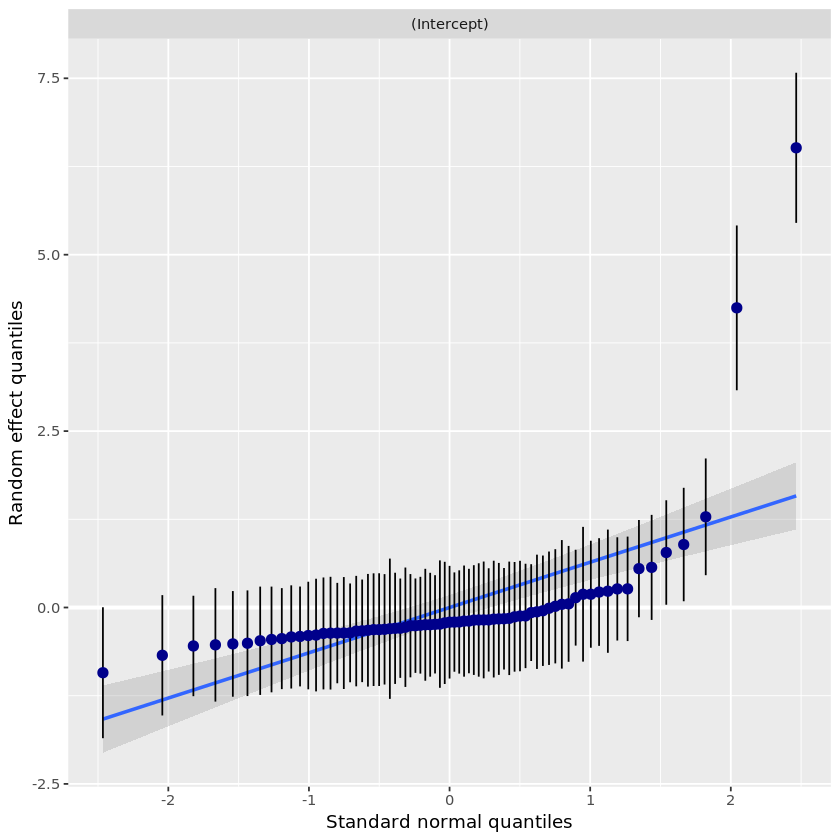

`geom_smooth()` using formula 'y ~ x'


[[1]]

[[2]]
[[2]]$isolate


[[3]]

[[4]]


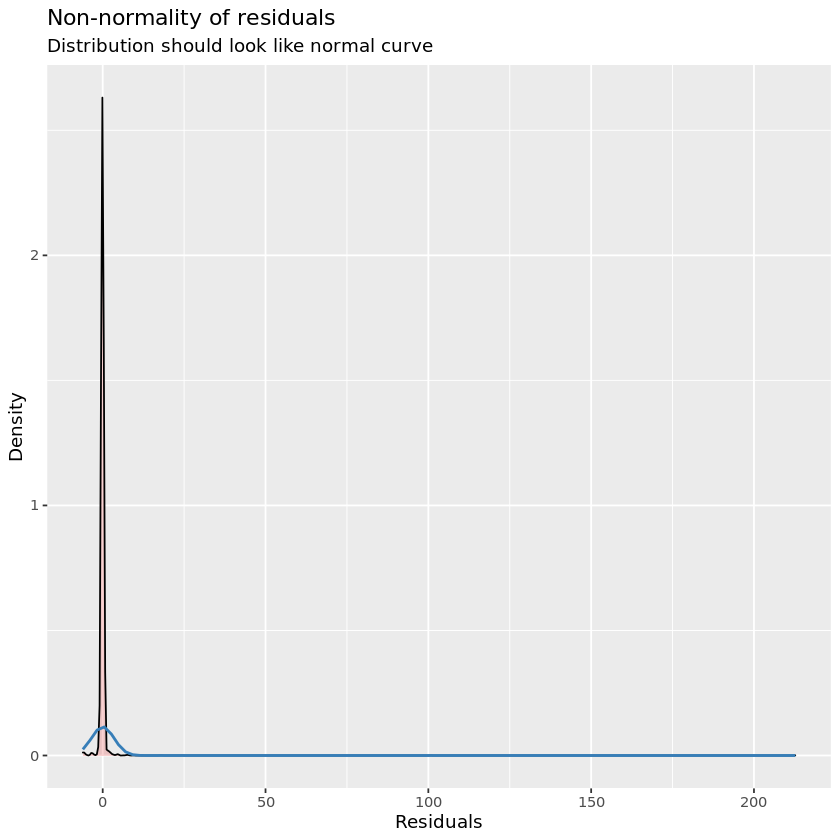

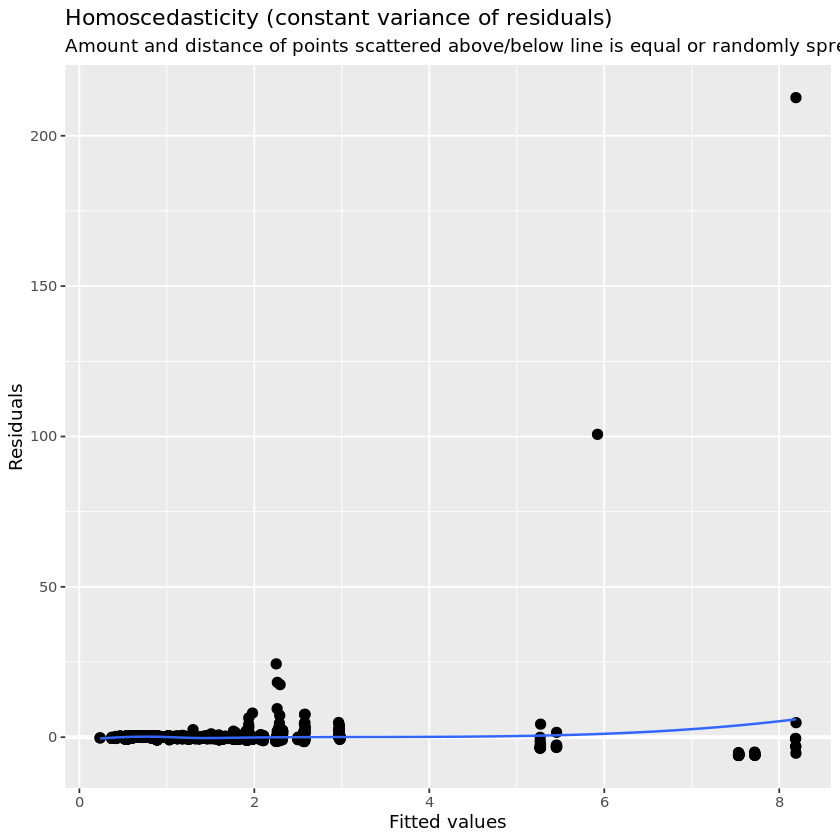

In [24]:
plot_model(season_re, type='diag')

## More Intense Heatwaves =? Stronger Signal?

There's probably a lot of noise from shorter events here. I'll add a threshold of 2deg C mean intensity to these events to see if that changes things?

In [25]:
intensity_threshold = 2

In [26]:
intenseMhwPerformance = mhwPerformance %>% filter(intensity_mean > intensity_threshold)

In [27]:
head(intenseMhwPerformance)

X,lat,lon,isolate,mhw,detriment_sum,relative_detriment_mean,detriment_mean,performance_diff_sum,performance_ratio_mean,...,duration,start_doy,peak_doy,current_year_sst_mean,perf_det_ratio,latbin,doy_bins,season,lat_scaled,sst_scaled
34,-36.125,174.875,573,53,1.7526555,0.07958929,0.04736907,3.00758344,1.1757085,...,38,1,165,17.80997,3.521463e-01,"(-44.625, -29.5]","(0.639, 91.25]",spring,-1.6327423,-0.2650704
47,-22.875,14.125,33,42,0.9694460,0.09852537,0.04616410,-0.91496197,0.9065318,...,22,26,230,15.91697,1.963128e+01,"(-29.5, -14.375]","(0.639, 91.25]",summer,-1.2124833,-0.5175450
67,-1.375,-89.625,47,11,0.7586259,0.04669002,0.03298373,-0.75234763,0.9536760,...,24,109,297,24.03481,1.452775e+06,"(-14.375, 0.75]","(91.25, 181.5]",fall,-0.5305535,0.5651515
70,0.125,-139.875,365,20,0.1530082,0.03088743,0.01530082,-0.06734654,0.9861951,...,11,67,75,25.26343,1.895458e+00,"(-14.375, 0.75]","(0.639, 91.25]",winter,-0.4829770,0.7290151
99,9.875,-89.125,63,29,0.8670648,0.05882705,0.04563499,-0.79551968,0.9457929,...,20,1,360,26.55980,1.777795e+01,"(0.75, 15.875]","(0.639, 91.25]",winter,-0.1737298,0.9019163
100,9.875,-89.125,63,31,1.0546000,0.19420876,0.15065714,-1.05365076,0.8059318,...,8,82,86,27.59918,7.105684e+03,"(0.75, 15.875]","(0.639, 91.25]",spring,-0.1737298,1.0405398


In [28]:
nrow(intenseMhwPerformance)

[1] 1251

**Simple Model**

In [29]:
simple_intense_lm = lm(performance_ratio_mean ~ lat + I(lat^2) + current_year_sst_mean + season, data=intenseMhwPerformance)
summary(simple_intense_lm)


Call:
lm(formula = performance_ratio_mean ~ lat + I(lat^2) + current_year_sst_mean + 
    season, data = intenseMhwPerformance)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.5207 -0.2964 -0.0911  0.1080 24.8039 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)            1.8241953  0.2642243   6.904 8.04e-12 ***
lat                    0.0047706  0.0023095   2.066 0.039071 *  
I(lat^2)              -0.0001176  0.0000748  -1.572 0.116229    
current_year_sst_mean -0.0277548  0.0096744  -2.869 0.004189 ** 
seasonspring           0.0543888  0.1156748   0.470 0.638304    
seasonsummer          -0.3792246  0.1135035  -3.341 0.000859 ***
seasonwinter           0.5538739  0.1294379   4.279 2.02e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.128 on 1244 degrees of freedom
Multiple R-squared:  0.07217,	Adjusted R-squared:  0.0677 
F-statistic: 16.13 on 6 and 1244 DF,  p-value: < 2.2e-16


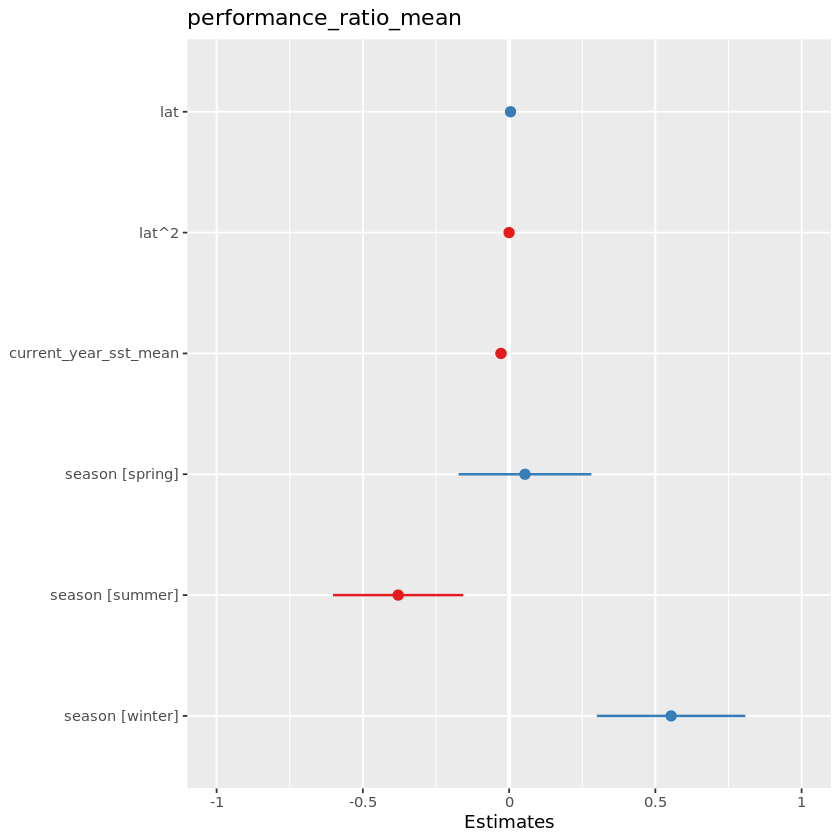

In [30]:
plot_model(simple_intense_lm)

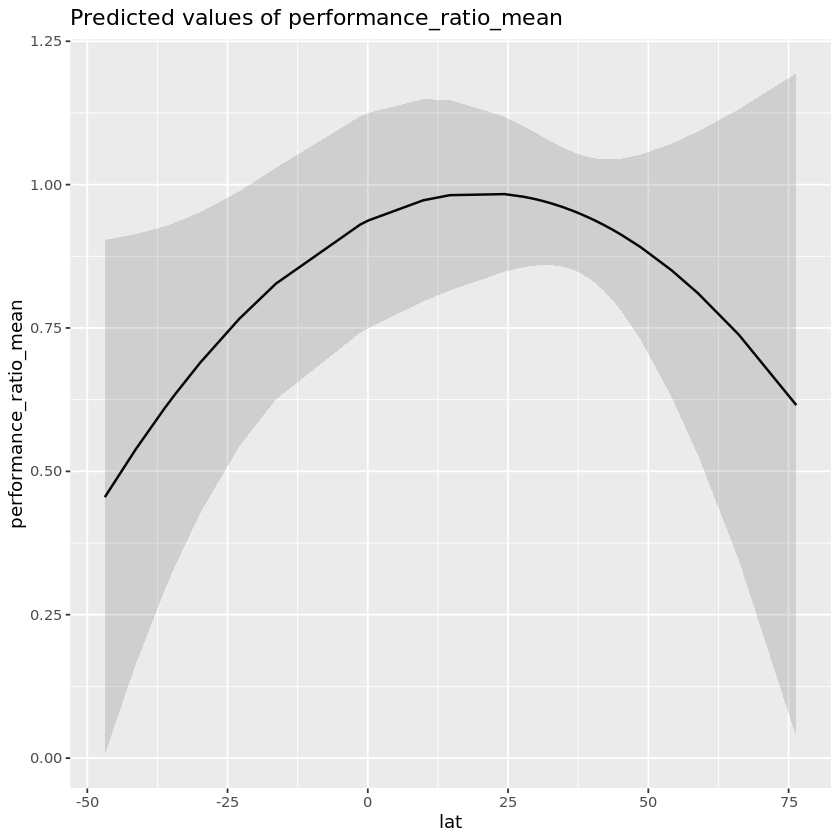

$lat

$current_year_sst_mean

$season


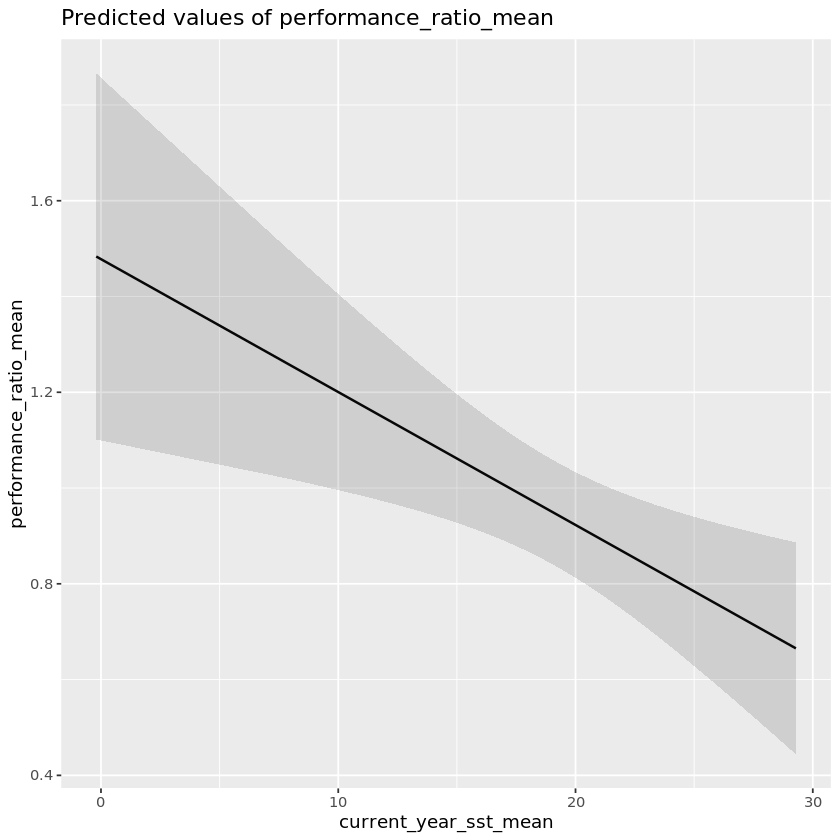

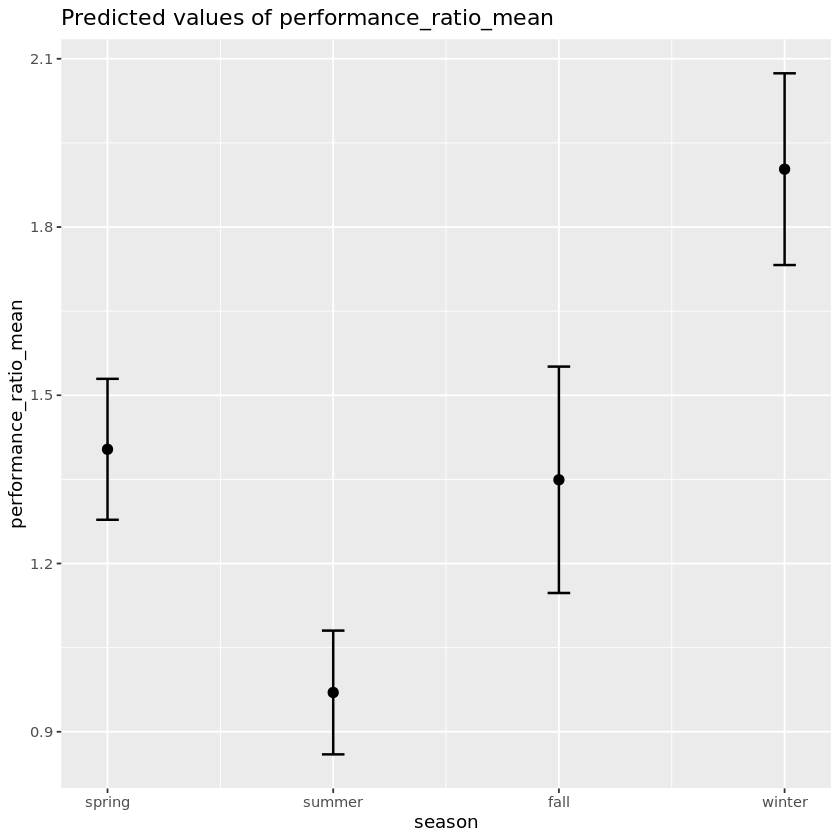

In [31]:
plot_model(simple_intense_lm, type='pred')

**Simple Random Effects**

In [45]:
simple_intense_re = lmer(performance_ratio_mean ~ lat + I(lat^2) + current_year_sst_mean + season + (1 | isolate), data=intenseMhwPerformance, )

In [46]:
summary(simple_intense_re)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: performance_ratio_mean ~ lat + I(lat^2) + current_year_sst_mean +  
    season + (1 | isolate)
   Data: intenseMhwPerformance

REML criterion at convergence: 3749.1

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.6706 -0.2475 -0.0058  0.1352 22.6572 

Random effects:
 Groups   Name        Variance Std.Dev.
 isolate  (Intercept) 0.1947   0.4413  
 Residual             1.0685   1.0337  
Number of obs: 1251, groups:  isolate, 51

Fixed effects:
                        Estimate Std. Error         df t value Pr(>|t|)    
(Intercept)            1.881e+00  5.288e-01  6.602e+01   3.557 0.000701 ***
lat                    2.033e-03  3.590e-03  1.040e+02   0.566 0.572419    
I(lat^2)              -9.321e-05  1.368e-04  6.923e+01  -0.681 0.498026    
current_year_sst_mean -3.718e-02  2.028e-02  6.522e+01  -1.833 0.071318 .  
seasonspring           2.212e-01  1.104e-01  1.233e+03   2.003 

Model contains polynomial or cubic / quadratic terms. Consider using `terms="lat [all]"` to get smooth plots. See also package-vignette 'Marginal Effects at Specific Values'.
Model contains polynomial or cubic / quadratic terms. Consider using `terms="current_year_sst_mean [all]"` to get smooth plots. See also package-vignette 'Marginal Effects at Specific Values'.
Model contains polynomial or cubic / quadratic terms. Consider using `terms="season [all]"` to get smooth plots. See also package-vignette 'Marginal Effects at Specific Values'.


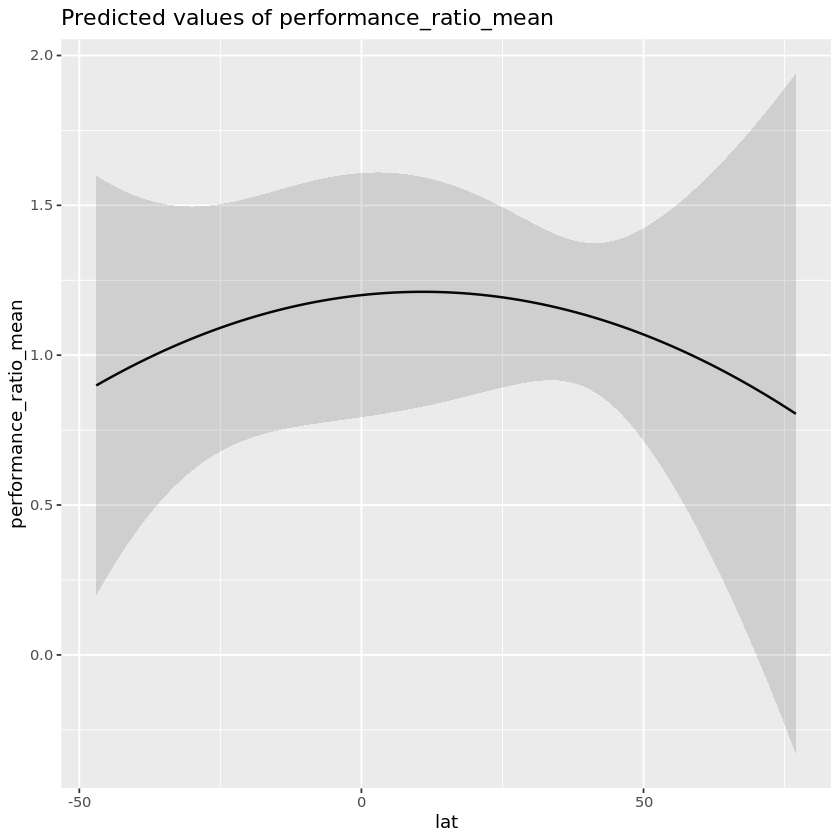

$lat

$current_year_sst_mean

$season


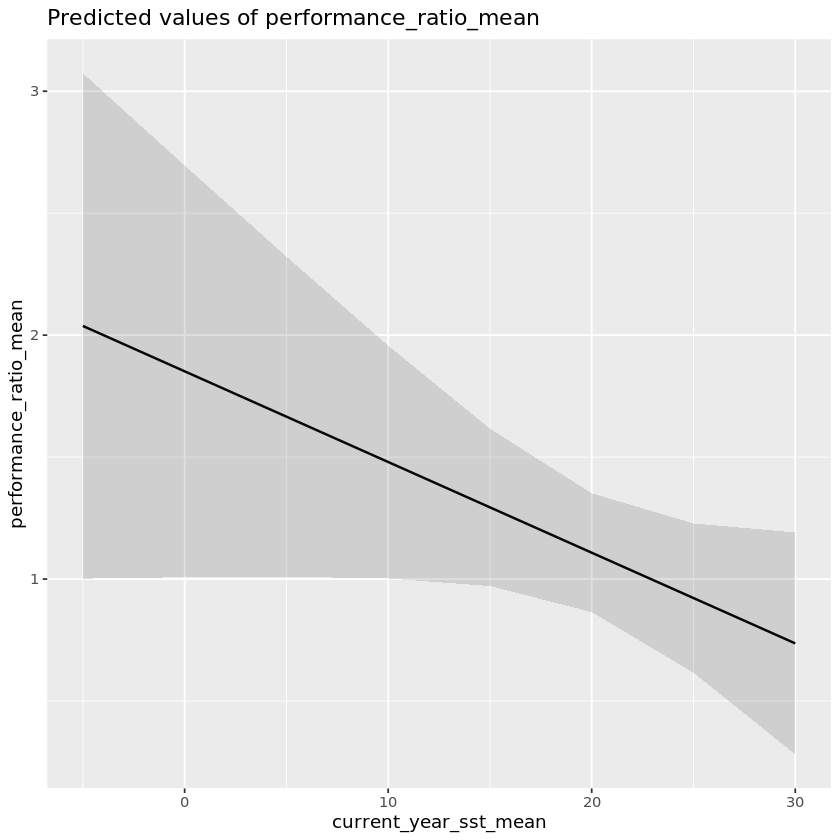

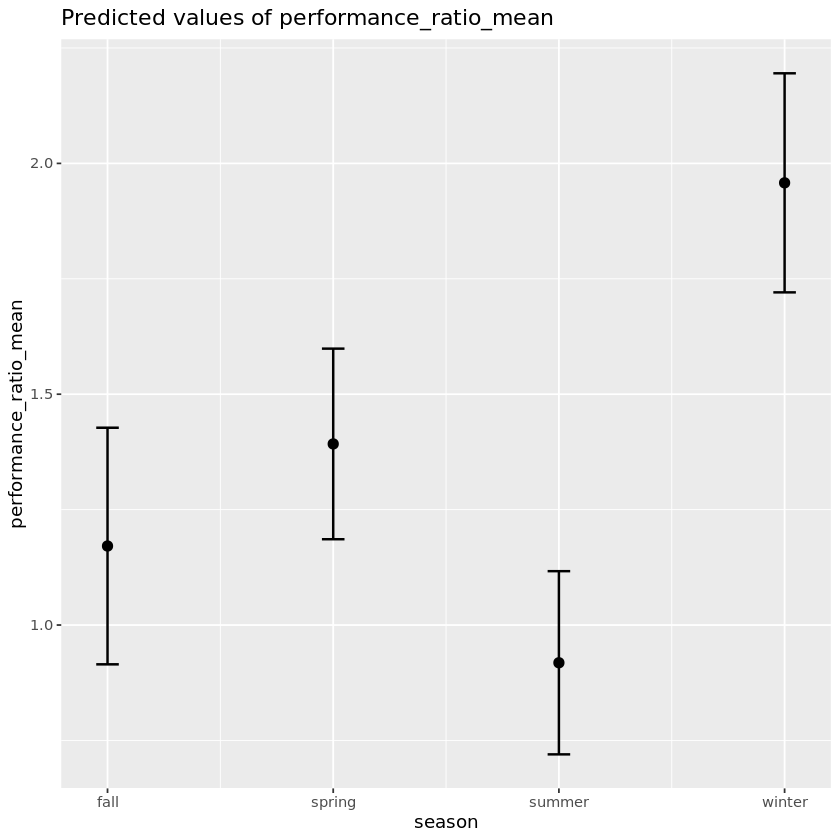

In [47]:
plot_model(simple_intense_re, type='pred')

`geom_smooth()` using formula 'y ~ x'
`geom_smooth()` using formula 'y ~ x'


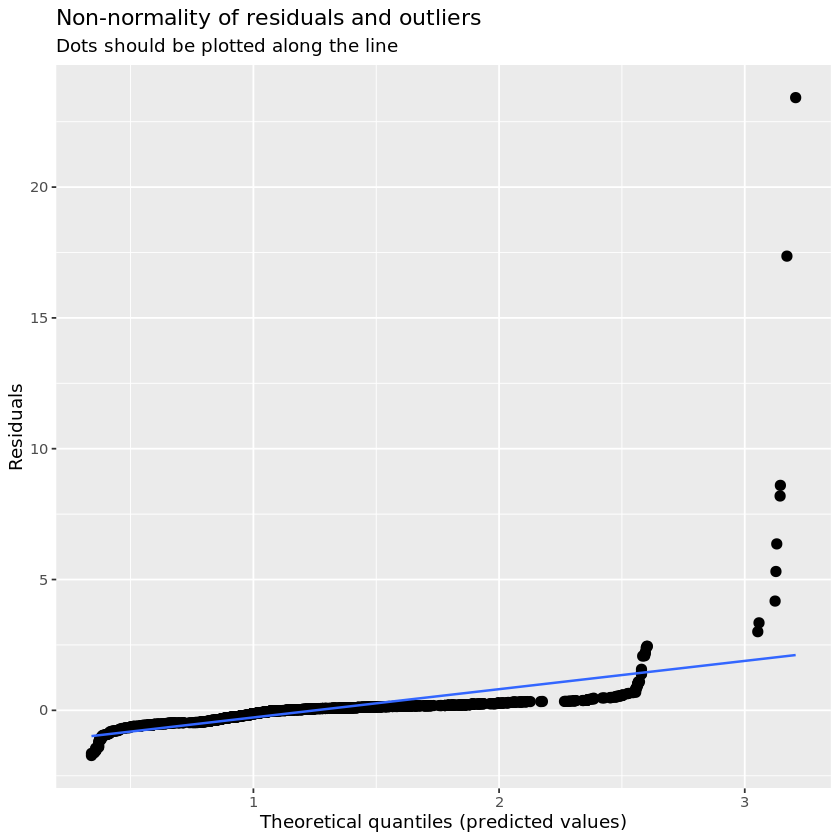

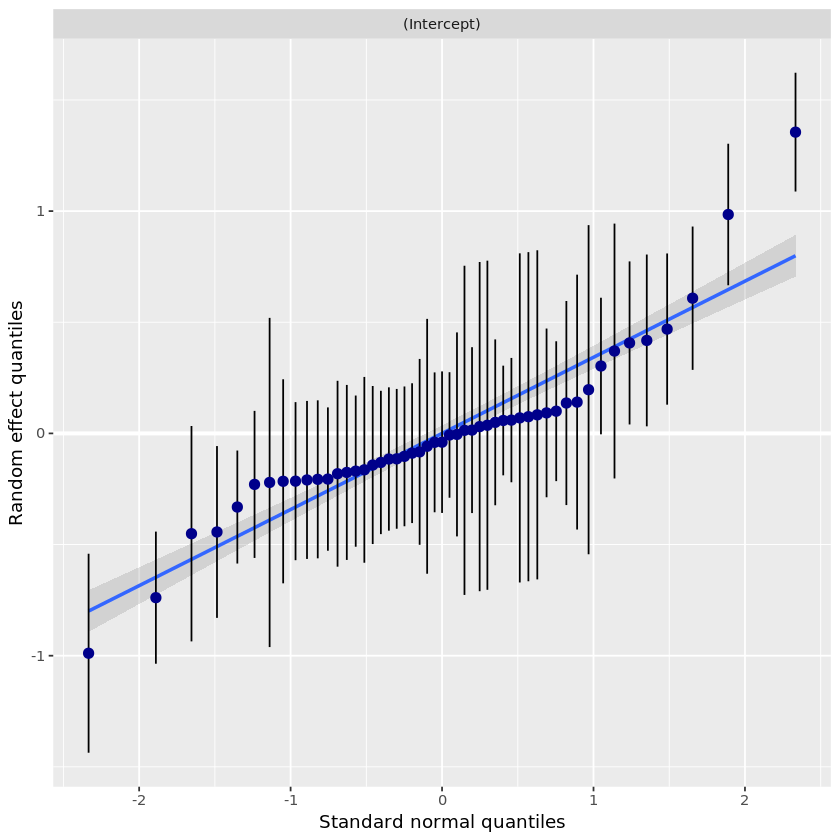

`geom_smooth()` using formula 'y ~ x'


[[1]]

[[2]]
[[2]]$isolate


[[3]]

[[4]]


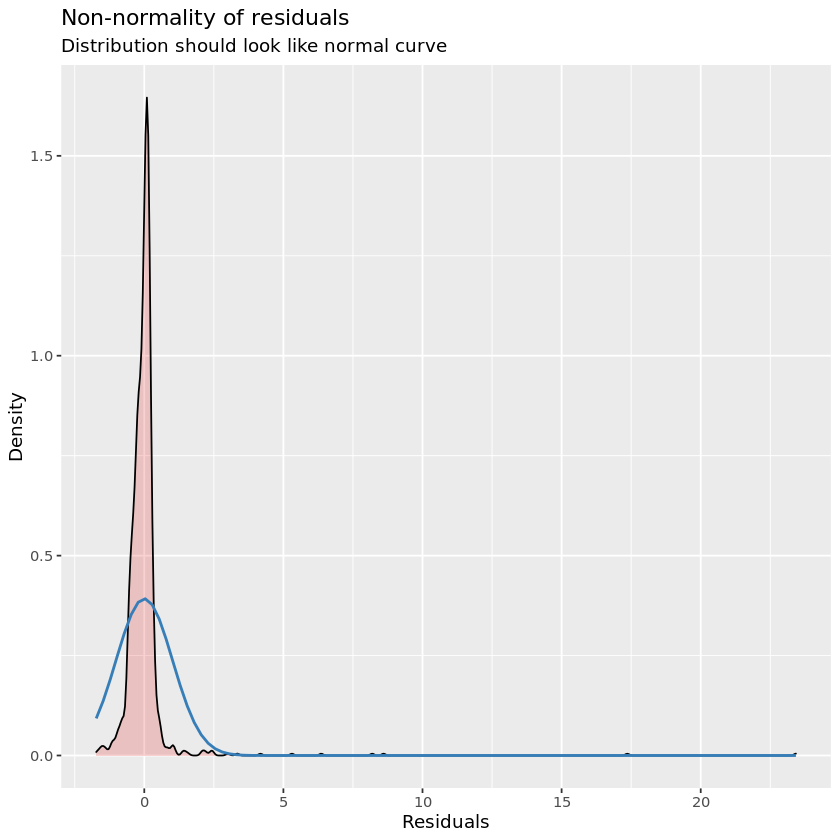

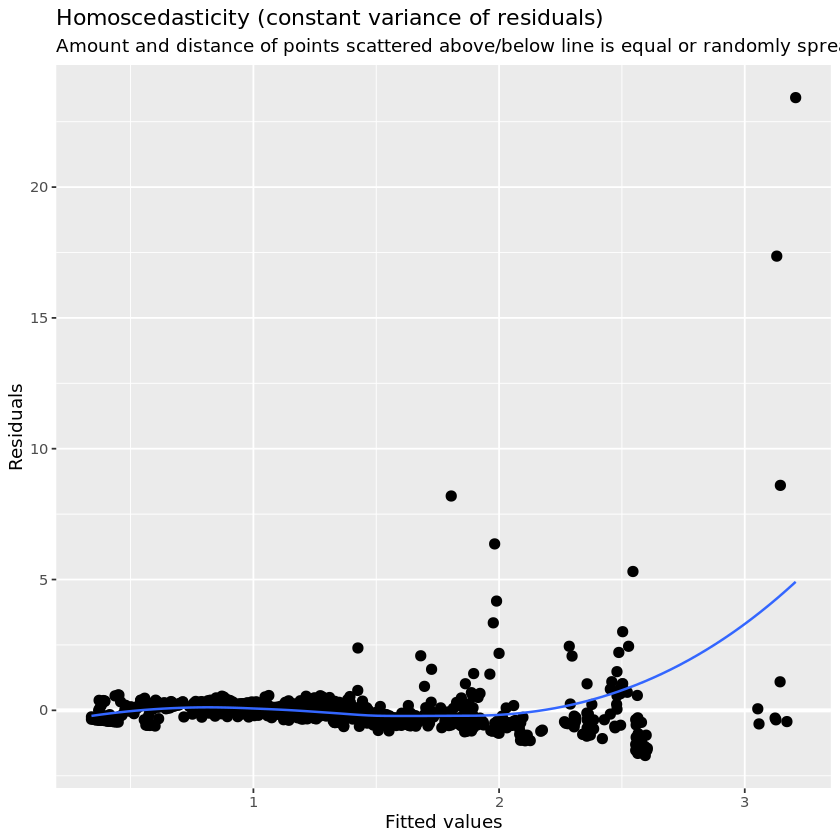

In [48]:
plot_model(simple_intense_re, type='diag')

In [54]:
library(sjPlot)

In [60]:
sjPlot::tab_model(simple_intense_re, file='simple_intense_re.html')

In [62]:
IRdisplay::display_html("<iframe width=500 height=500 src='simple_intense_re.html'></iframe>")